# AI Fellowship Take Home Test
> ## Task - 3D Segmentation Model on CT Abdomen Organs
>
> ## Name - Ojas Patil

## Contents
>#### 1. Dataset Extraction
>#### 2. Importing Libraries
>#### 3. Loading & Visualizing Dataset
>#### 4. Train-Val Split
>#### 5. Defining Vnet Model
>#### 6. Model Training
>#### 7. Plotting Dice Score
>#### 8. Prediction on unseen data
>#### 9. Video Generation
>#### 10. Future Improvements / Ideas

## 1. Extracting Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import zipfile

zip_file_path = '/content/drive/MyDrive/flare 2022/FLARE22Train.zip'

# Define the destination directory
destination_dir = '/content'
os.makedirs(destination_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_dir)

print(f'Files unzipped to: {destination_dir}')

Files unzipped to: /content


In [3]:
!pip install torchio -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.4/174.4 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 MB 21.4 MB/s eta 0:00:00


## 2. Importing Libraries

In [12]:
import os
import numpy as np
import nibabel as nib

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torch.optim as optim

import scipy.ndimage
import torchio as tio


import random
import scipy.ndimage
from scipy.ndimage import rotate
import matplotlib.pyplot as plt

## 3. Loading & Visualizing Dataset
The original image is 512x512 with varying depths. Reshaping this to 128*128 with 64 depth.

In [13]:
class Flare22Dataset(Dataset):
    def __init__(self, images_dir, labels_dir, fixed_size=(128, 128), fixed_depth=64, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.fixed_size = fixed_size
        self.fixed_depth = fixed_depth
        self.transform = transform

        # Define the classes you want to keep (1st, 2nd, 3rd, 13th)
        # more on this below
        self.classes_to_keep = [1, 2, 3, 13]

        # Get sorted list of all image and label files in their resp. directory
        self.image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.nii.gz')])
        self.label_files = sorted([f for f in os.listdir(labels_dir) if f.endswith('.nii.gz')])

        # Just checking
        assert len(self.image_files) == len(self.label_files), "Number of images and label files must be the same."

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load the image file and corresponding label
        image_path = os.path.join(self.images_dir, self.image_files[idx])
        label_path = os.path.join(self.labels_dir, self.label_files[idx])

        # Load NIfTI files using nibabel
        image = nib.load(image_path).get_fdata()
        label = nib.load(label_path).get_fdata()

        # Filter the label to keep only the desired classes
        label = self.filter_classes(label)

        # Resample image and label to achieve 128x128 with 64 depth
        image = self.resample_volume(image, self.fixed_depth, self.fixed_size)
        label = self.resample_volume(label, self.fixed_depth, self.fixed_size)

        # Converting numpy arrays to PyTorch tensors
        image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)

        # Adding a batch dimension
        image = image.unsqueeze(0)
        label = label.unsqueeze(0)

        # Applies transform without breaking my notebook
        if self.transform:
            # print(image.shape)
            # print(label.shape)

            subject = tio.Subject(
                image=tio.ScalarImage(tensor=image),
                label=tio.LabelMap(tensor=label)
            )
            transformed = self.transform(subject)
            image = transformed.image.data
            label = transformed.label.data

            # print(image.shape)
            # print(label.shape)

        # print("Ideal")
        # print(image.shape)
        # print(label.shape)
        # print("Ideal over")
        return image, label

    def resample_volume(self, volume, target_depth, target_size):
        """Resample a 3D volume to the target depth and size while maintaining aspect ratio."""
        current_depth, current_height, current_width = volume.shape
        depth_scale_factor = target_depth / current_depth

        height_scale_factor = target_size[0] / current_height
        width_scale_factor = target_size[1] / current_width

        resampled_volume = scipy.ndimage.zoom(volume, (depth_scale_factor, height_scale_factor, width_scale_factor), order=1)  # order=1 for linear interpolation
        return resampled_volume

    def filter_classes(self, label_volume):
        """Keep only the specified classes in the label volume."""
        filtered_volume = np.zeros_like(label_volume)
        for cls in self.classes_to_keep:
            filtered_volume[label_volume == cls] = cls
        return filtered_volume

Okay so here is the provided visual with the class ID and specific classes
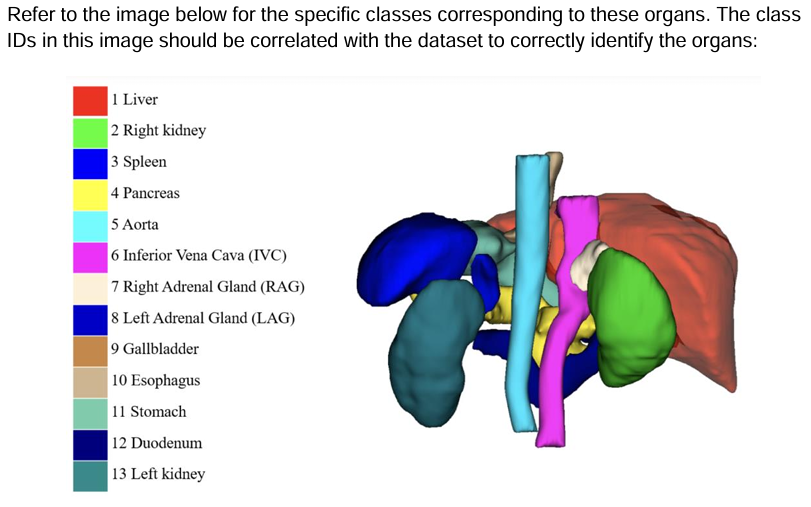

 #### Data Augmentation Pipeline

In [14]:
# train_transforms = tio.Compose([
#     tio.RandomAffine(
#         scales=(0.7, 1.3),  # zoom_range
#         degrees=(0, 45),  # rotation_range
#         translation=(0.3, 0.3, 0.3),  # width_shift_range and height_shift_range
#     ),
#     tio.RandomFlip(axes=(0, 1, 2)),  # horizontal_flip and vertical_flip
# ])

train_transforms = tio.Compose([
    tio.RandomAffine(scales=(0.9, 1.1), degrees=15),
    tio.RandomFlip(axes=(0, 1, 2)),
    tio.RandomNoise(std=0.1),
    tio.RandomBiasField()
])

Change this path with your extracted file path accordingly

In [15]:
images_dir = '/content/FLARE22Train/images'
labels_dir = '/content/FLARE22Train/labels'

In [16]:
# dataset = Flare22Dataset(images_dir, labels_dir, fixed_size=(128, 128), fixed_depth=64)
dataset = Flare22Dataset(
    images_dir=images_dir,
    labels_dir=labels_dir,
    transform=train_transforms
)

Lets view 5 samples from the dataset and check the shape of our data

In [17]:
def visualize_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 4 * num_samples))

    for i in range(num_samples):
        image, label = dataset[i]

        print("image", i, image.shape)
        print("label", i, label.shape)
        print()

        # Remove batch dimension
        image = image.squeeze(0)
        label = label.squeeze(0)


        # Get the middle slice along the z-axis (depth)
        mid_slice = image.shape[2] // 2

        # Plot image
        axes[i, 0].imshow(image[:, :, mid_slice], cmap='gray')
        axes[i, 0].set_title(f'Sample {i+1} - Image')
        axes[i, 0].axis('off')

        # Plot label
        axes[i, 1].imshow(label[:, :, mid_slice], cmap='nipy_spectral')
        axes[i, 1].set_title(f'Sample {i+1} - Label')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

image 0 torch.Size([1, 64, 128, 128])
label 0 torch.Size([1, 64, 128, 128])

image 1 torch.Size([1, 64, 128, 128])
label 1 torch.Size([1, 64, 128, 128])

image 2 torch.Size([1, 64, 128, 128])
label 2 torch.Size([1, 64, 128, 128])

image 3 torch.Size([1, 64, 128, 128])
label 3 torch.Size([1, 64, 128, 128])

image 4 torch.Size([1, 64, 128, 128])
label 4 torch.Size([1, 64, 128, 128])



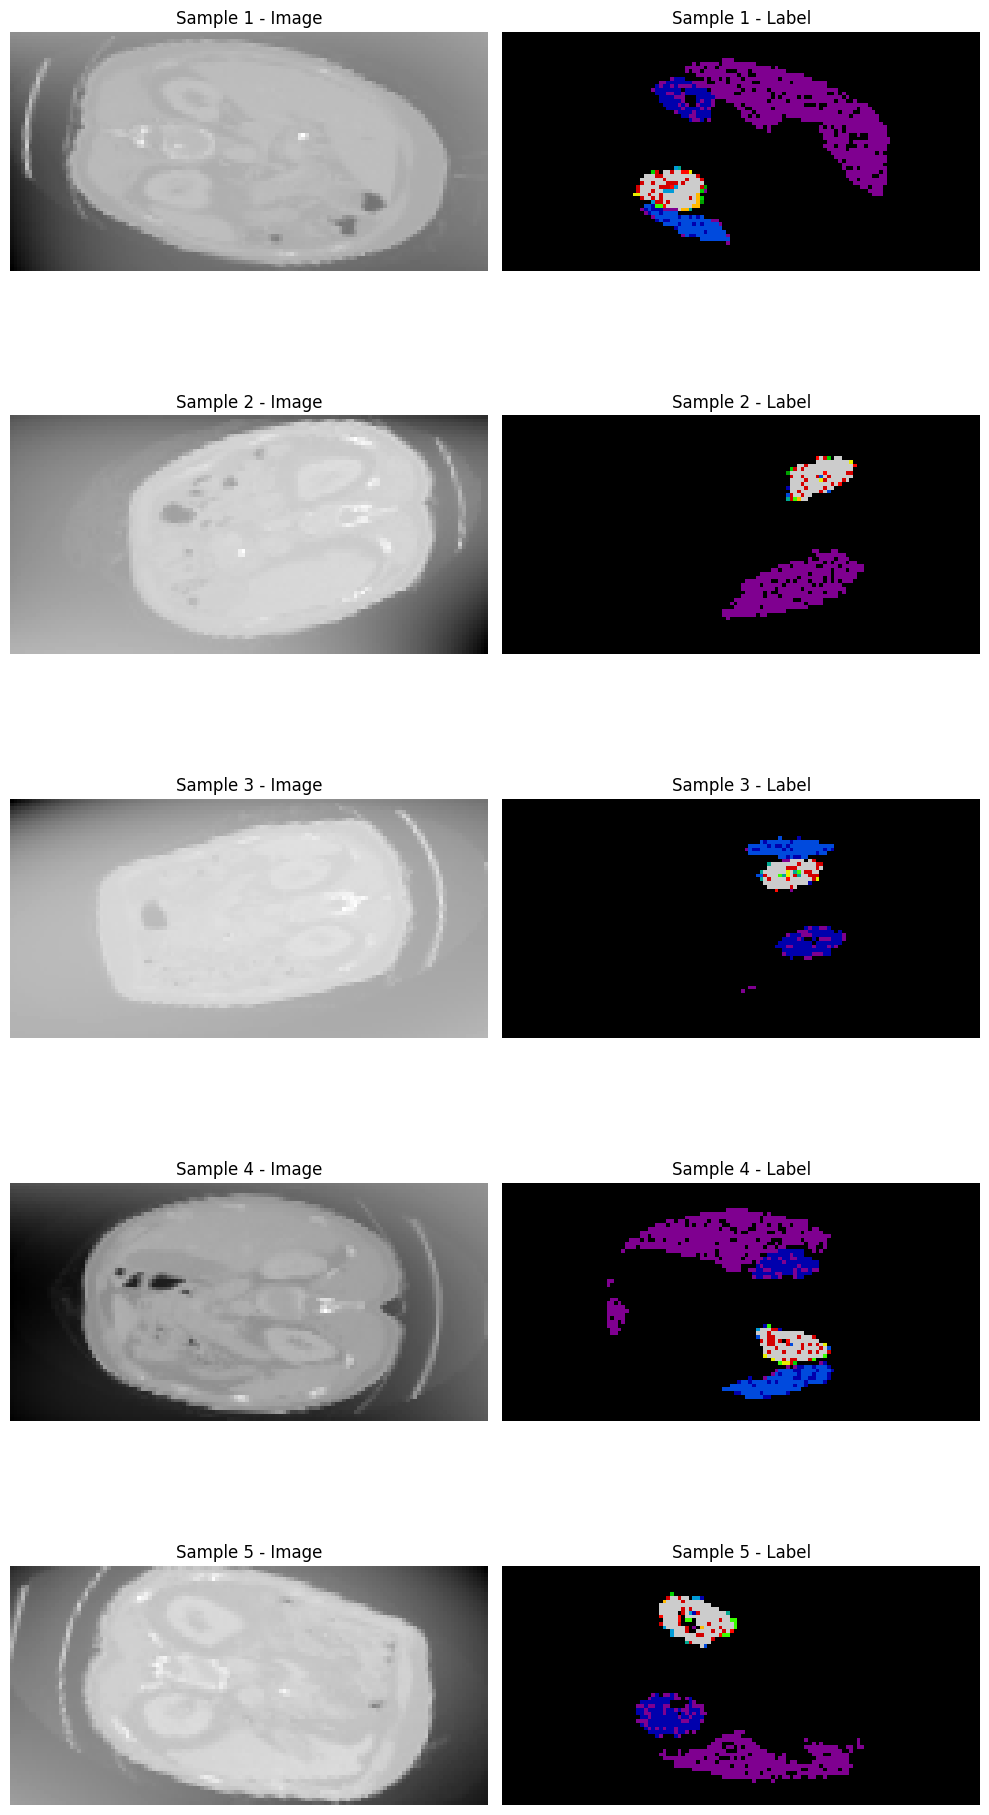

In [18]:
visualize_samples(dataset, num_samples=5)

According to task, we are supposed to segment Liver (1), Right Kidney (2), Spleen (3) and Left Kidney (13). This is the reasoning for the classes array defined earlier.

However, if my understanding is correct, the **color of the visuals from the data do not match the provided photo**. I do not have much of a medical backgroud and cannot confirm if the correct classes were chosen. Aplogies for the same.

## Train Validation Split

In [24]:
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Vnet Model Architecture
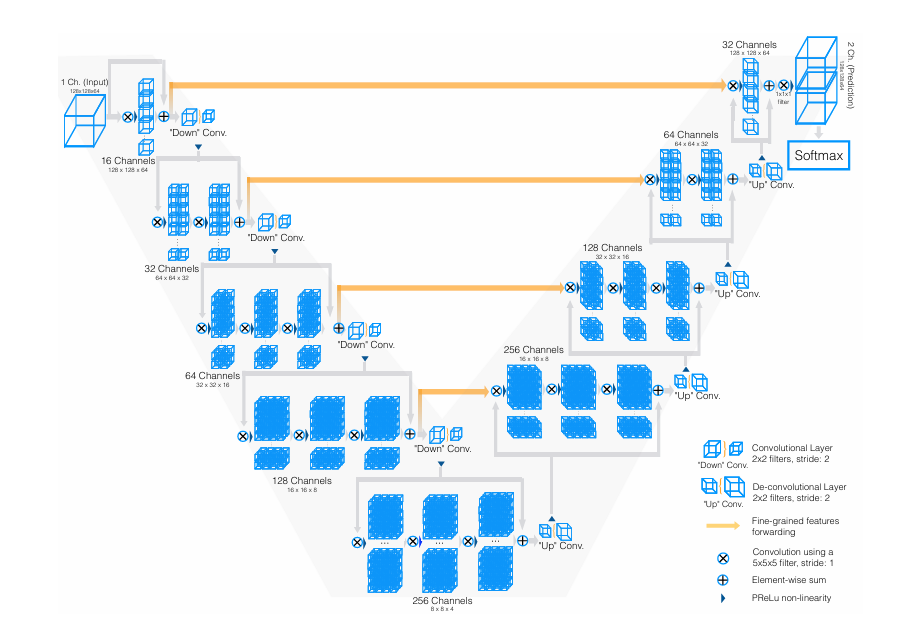

In [34]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class conv3d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(conv3d, self).__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=5, padding=2)
        self.relu = nn.PReLU()
        self.norm = nn.InstanceNorm3d(out_channels, affine=True)

    def forward(self, x):
        return self.relu(self.norm(self.conv(x)))


class conv3d_x3(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(conv3d_x3, self).__init__()
        self.conv_1 = conv3d(in_channels, out_channels)
        self.conv_2 = conv3d(out_channels, out_channels)
        self.conv_3 = conv3d(out_channels, out_channels)
        self.skip_connection=nn.Conv3d(in_channels,out_channels,1)

    def forward(self, x):
        z_1 = self.conv_1(x)
        z_3 = self.conv_3(self.conv_2(z_1))
        return z_3 + self.skip_connection(x)

class conv3d_x2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(conv3d_x2, self).__init__()
        self.conv_1 = conv3d(in_channels, out_channels)
        self.conv_2 = conv3d(out_channels, out_channels)
        self.skip_connection=nn.Conv3d(in_channels,out_channels,1)

    def forward(self, x):
        z_1 = self.conv_1(x)
        z_2 = self.conv_2(z_1)
        return z_2 + self.skip_connection(x)


class conv3d_x1(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(conv3d_x1, self).__init__()
        self.conv_1 = conv3d(in_channels, out_channels)
        self.skip_connection=nn.Conv3d(in_channels,out_channels,1)

    def forward(self, x):
        z_1 = self.conv_1(x)
        return z_1 + self.skip_connection(x)

class deconv3d_x3(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(deconv3d_x3, self).__init__()
        self.up = deconv3d_as_up(in_channels, out_channels, 2, 2)
        self.lhs_conv = conv3d(out_channels // 2, out_channels)
        self.conv_x3 = nn.Sequential(
            nn.Conv3d(2*out_channels, out_channels,5,1,2),
            nn.PReLU(),
            nn.Conv3d(out_channels, out_channels,5,1,2),
            nn.PReLU(),
            nn.Conv3d(out_channels, out_channels,5,1,2),
            nn.PReLU(),
        )

    def forward(self, lhs, rhs):
        rhs_up = self.up(rhs)
        lhs_conv = self.lhs_conv(lhs)
        rhs_add = torch.cat((rhs_up, lhs_conv),dim=1)
        return self.conv_x3(rhs_add)+ rhs_up

class deconv3d_x2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(deconv3d_x2, self).__init__()
        self.up = deconv3d_as_up(in_channels, out_channels, 2, 2)
        self.lhs_conv = conv3d(out_channels // 2, out_channels)
        self.conv_x2= nn.Sequential(
            nn.Conv3d(2*out_channels, out_channels,5,1,2),
            nn.PReLU(),
            nn.Conv3d(out_channels, out_channels,5,1,2),
            nn.PReLU(),
        )

    def forward(self, lhs, rhs):
        rhs_up = self.up(rhs)
        lhs_conv = self.lhs_conv(lhs)
        rhs_add = torch.cat((rhs_up, lhs_conv),dim=1)
        return self.conv_x2(rhs_add)+ rhs_up

class deconv3d_x1(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(deconv3d_x1, self).__init__()
        self.up = deconv3d_as_up(in_channels, out_channels, 2, 2)
        self.lhs_conv = conv3d(out_channels // 2, out_channels)
        self.conv_x1 = nn.Sequential(
            nn.Conv3d(2*out_channels, out_channels,5,1,2),
            nn.PReLU(),
        )

    def forward(self, lhs, rhs):
        rhs_up = self.up(rhs)
        lhs_conv = self.lhs_conv(lhs)
        rhs_add = torch.cat((rhs_up, lhs_conv),dim=1)
        return self.conv_x1(rhs_add)+ rhs_up


def conv3d_as_pool(in_channels, out_channels, kernel_size=2, stride=2):
    return nn.Sequential(
        nn.Conv3d(in_channels, out_channels, kernel_size, stride, padding=0),
        nn.PReLU())


def deconv3d_as_up(in_channels, out_channels, kernel_size=2, stride=2):
    return nn.Sequential(
        nn.ConvTranspose3d(in_channels, out_channels, kernel_size, stride),
        nn.PReLU()
    )


class softmax_out(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(softmax_out, self).__init__()
        self.conv_1 = nn.Conv3d(in_channels, out_channels, kernel_size=5, padding=2)
        self.conv_2 = nn.Conv3d(out_channels, out_channels, kernel_size=1, padding=0)

    def forward(self, x):
        y_conv = self.conv_2(self.conv_1(x))
        # return nn.Sigmoid()(y_conv)
        return nn.Softmax(dim=1)(y_conv)



class VNet(nn.Module):
    def __init__(self):
        super(VNet, self).__init__()
        self.conv_1 = conv3d_x1(1, 16)
        self.pool_1 = conv3d_as_pool(16, 32)
        self.conv_2 = conv3d_x2(32, 32)
        self.pool_2 = conv3d_as_pool(32, 64)
        self.conv_3 = conv3d_x3(64, 64)
        self.pool_3 = conv3d_as_pool(64, 128)
        self.conv_4 = conv3d_x3(128, 128)
        self.pool_4 = conv3d_as_pool(128, 256)

        self.bottom = conv3d_x3(256, 256)

        self.deconv_4 = deconv3d_x3(256, 256)
        self.deconv_3 = deconv3d_x3(256, 128)
        self.deconv_2 = deconv3d_x2(128, 64)
        self.deconv_1 = deconv3d_x1(64, 32)

        # self.out = softmax_out(32, 4)
        self.out = nn.Conv3d(32, 4, kernel_size=1, padding=0)

    def forward(self, x):
        conv_1 = self.conv_1(x)
        pool = self.pool_1(conv_1)
        conv_2 = self.conv_2(pool)
        pool = self.pool_2(conv_2)
        conv_3 = self.conv_3(pool)
        pool = self.pool_3(conv_3)
        conv_4 = self.conv_4(pool)
        pool = self.pool_4(conv_4)
        bottom = self.bottom(pool)
        deconv = self.deconv_4(conv_4, bottom)
        deconv = self.deconv_3(conv_3, deconv)
        deconv = self.deconv_2(conv_2, deconv)
        deconv = self.deconv_1(conv_1, deconv)
        return self.out(deconv)

In [35]:
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [36]:
model = VNet()
model.to(device)

VNet(
  (conv_1): conv3d_x1(
    (conv_1): conv3d(
      (conv): Conv3d(1, 16, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
      (relu): PReLU(num_parameters=1)
      (norm): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    )
    (skip_connection): Conv3d(1, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  )
  (pool_1): Sequential(
    (0): Conv3d(16, 32, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    (1): PReLU(num_parameters=1)
  )
  (conv_2): conv3d_x2(
    (conv_1): conv3d(
      (conv): Conv3d(32, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
      (relu): PReLU(num_parameters=1)
      (norm): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    )
    (conv_2): conv3d(
      (conv): Conv3d(32, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
      (relu): PReLU(num_parameters=1)
      (norm): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_s

DICE metrics - used for 3D abdominal segmentation datasets to accurately measure the overlap between predicted and ground truth segmentations, ensuring high-quality and reliable results.

In [37]:
# def dice_loss(pred, target, epsilon=1e-6):
#     pred_flat = pred.view(-1)
#     target_flat = target.view(-1)

#     intersection = (pred_flat * target_flat).sum()
#     union = pred_flat.sum() + target_flat.sum()

#     dice = (2.0 * intersection + epsilon) / (union + epsilon)

#     return 1 - dice

In [38]:
def dice_loss(pred, target, epsilon=1e-6):
    num_classes = pred.shape[1]
    dice = 0
    for c in range(num_classes):
        pred_flat = pred[:, c, :, :, :].contiguous().view(-1)
        target_flat = (target == c).float().contiguous().view(-1)

        intersection = (pred_flat * target_flat).sum()
        union = pred_flat.sum() + target_flat.sum()

        dice += (2.0 * intersection + epsilon) / (union + epsilon)
    dice = dice / num_classes
    return 1 - dice

In [39]:
# not used because of lack of knowledge of given dataset
def multi_class_dice_loss(pred, target, epsilon=1e-6):
    num_classes = pred.shape[1]
    total_loss = 0

    for class_idx in range(num_classes):
        pred_class = pred[:, class_idx, ...]
        target_class = (target == class_idx).float()

        pred_flat = pred_class.view(-1)
        target_flat = target_class.view(-1)

        intersection = (pred_flat * target_flat).sum()
        union = pred_flat.sum() + target_flat.sum()

        dice = (2.0 * intersection + epsilon) / (union + epsilon)
        total_loss += (1 - dice)

    return total_loss / num_classes

In [40]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = dice_loss
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)

Model Training

In [43]:
# Training and validation loop
num_epochs = 5
train_dice_scores, val_dice_scores = [], []

for epoch in range(num_epochs):
    model.train()
    running_dice = 0.0

    # Training phase
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # print(images.shape)
        # print(labels.shape)

        # Forward pass
        outputs = model(images)

        # Compute loss
        loss = criterion(outputs, labels.float())
        # print(loss)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Dice score is 1 - dice_loss
        dice = 1 - loss.item()
        # # print(dice)
        running_dice += dice

    # Average loss and dice score for the epoch
    train_dice_scores.append(running_dice / len(train_loader))

    # Validation phase
    model.eval()
    val_dice = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)

            # Compute loss
            loss = criterion(outputs, labels.float())

            # Dice score is 1 - dice_loss
            dice = 1 - loss.item()
            val_dice += dice

            dice = dice

    val_dice_scores.append(val_dice / len(val_loader))
    # Step the scheduler based on the validation Dice score
    scheduler.step(sum(val_dice_scores)/len(val_dice_scores))

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Dice: {train_dice_scores[-1]:.5f}, Val Dice: {val_dice_scores[-1]:.5f}")

print('Done with Training')

Epoch [1/5], Train Dice: 0.49751, Val Dice: 0.49726
Epoch [2/5], Train Dice: 0.49772, Val Dice: 0.49804
Epoch [3/5], Train Dice: 0.49915, Val Dice: 0.49983
Epoch [4/5], Train Dice: 0.49980, Val Dice: 0.49996
Epoch [5/5], Train Dice: 0.50000, Val Dice: 0.50004
Done with Training


#### Saving the model

In [78]:
# Define the path where you want to save the model
model_save_path = '/content/drive/MyDrive/models/model_weights_v2.pth'

# Save the state dictionary (weights) of the model
torch.save(model.state_dict(), model_save_path)
print(f"Model weights saved to {model_save_path}")

Model weights saved to /content/drive/MyDrive/models/model_weights_v2.pth


#### Loading the model

In [ ]:
# model = VNet()

# model_save_path = '/content/drive/MyDrive/vnet_models/vnet_bad_model_weights.pth'

# # Load the saved state dictionary into the model
# model.load_state_dict(torch.load(model_save_path))

# # If you're using GPU, don't forget to move the model to the appropriate device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

## 7. Plotting Dice Score

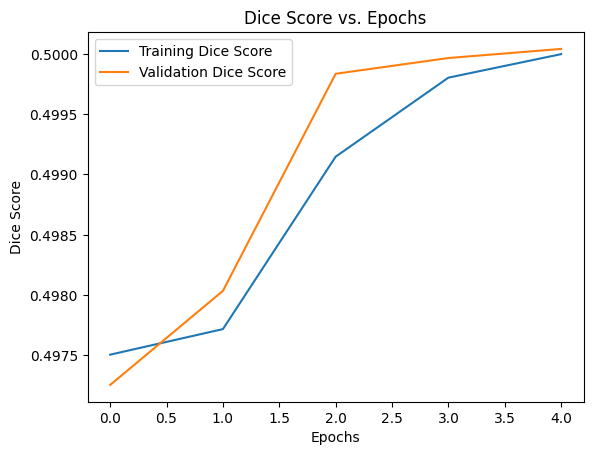

In [44]:
# Plot the training and validation Dice score curves
plt.subplot(1, 1, 1)
plt.plot(range(num_epochs), train_dice_scores, label='Training Dice Score')
plt.plot(range(num_epochs), val_dice_scores, label='Validation Dice Score')
plt.title('Dice Score vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Dice Score')
plt.legend()

plt.show()

## 8. Prediction on unseen data

In [45]:
# Dice score for each organ
def dice_score_per_organ(pred, target, classes):
    dice_scores = {}
    for cls in classes:
        pred_cls = (pred == cls).float()
        target_cls = (target == cls).float()
        dice = 1 - dice_loss(pred_cls, target_cls)
        dice_scores[cls] = dice.item()
    return dice_scores

# Compute Dice score for each organ in the validation set
classes_to_keep = [1, 2, 3, 13]  # example classes
model.eval()
organ_dice_scores = {cls: [] for cls in classes_to_keep}
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        outputs = (outputs > 0.5).float()
        dices = dice_score_per_organ(outputs, labels, classes_to_keep)
        for cls, dice in dices.items():
            organ_dice_scores[cls].append(dice)

# Print average Dice score for each organ
for cls, scores in organ_dice_scores.items():
    print(f"Dice score for organ {cls}: {np.mean(scores):.4f}")

Dice score for organ 1: 0.2458
Dice score for organ 2: 0.5000
Dice score for organ 3: 0.5000
Dice score for organ 13: 0.5000


torch.Size([2, 1, 64, 128, 128])
torch.Size([2, 1, 64, 128, 128])
torch.Size([2, 4, 64, 128, 128])
torch.Size([2, 1, 64, 128, 128])
torch.Size([2, 1, 64, 128, 128])
torch.Size([2, 1, 64, 128, 128])
torch.Size([2, 4, 64, 128, 128])
torch.Size([2, 1, 64, 128, 128])
torch.Size([1, 1, 64, 128, 128])
torch.Size([1, 1, 64, 128, 128])
torch.Size([1, 4, 64, 128, 128])
torch.Size([1, 1, 64, 128, 128])


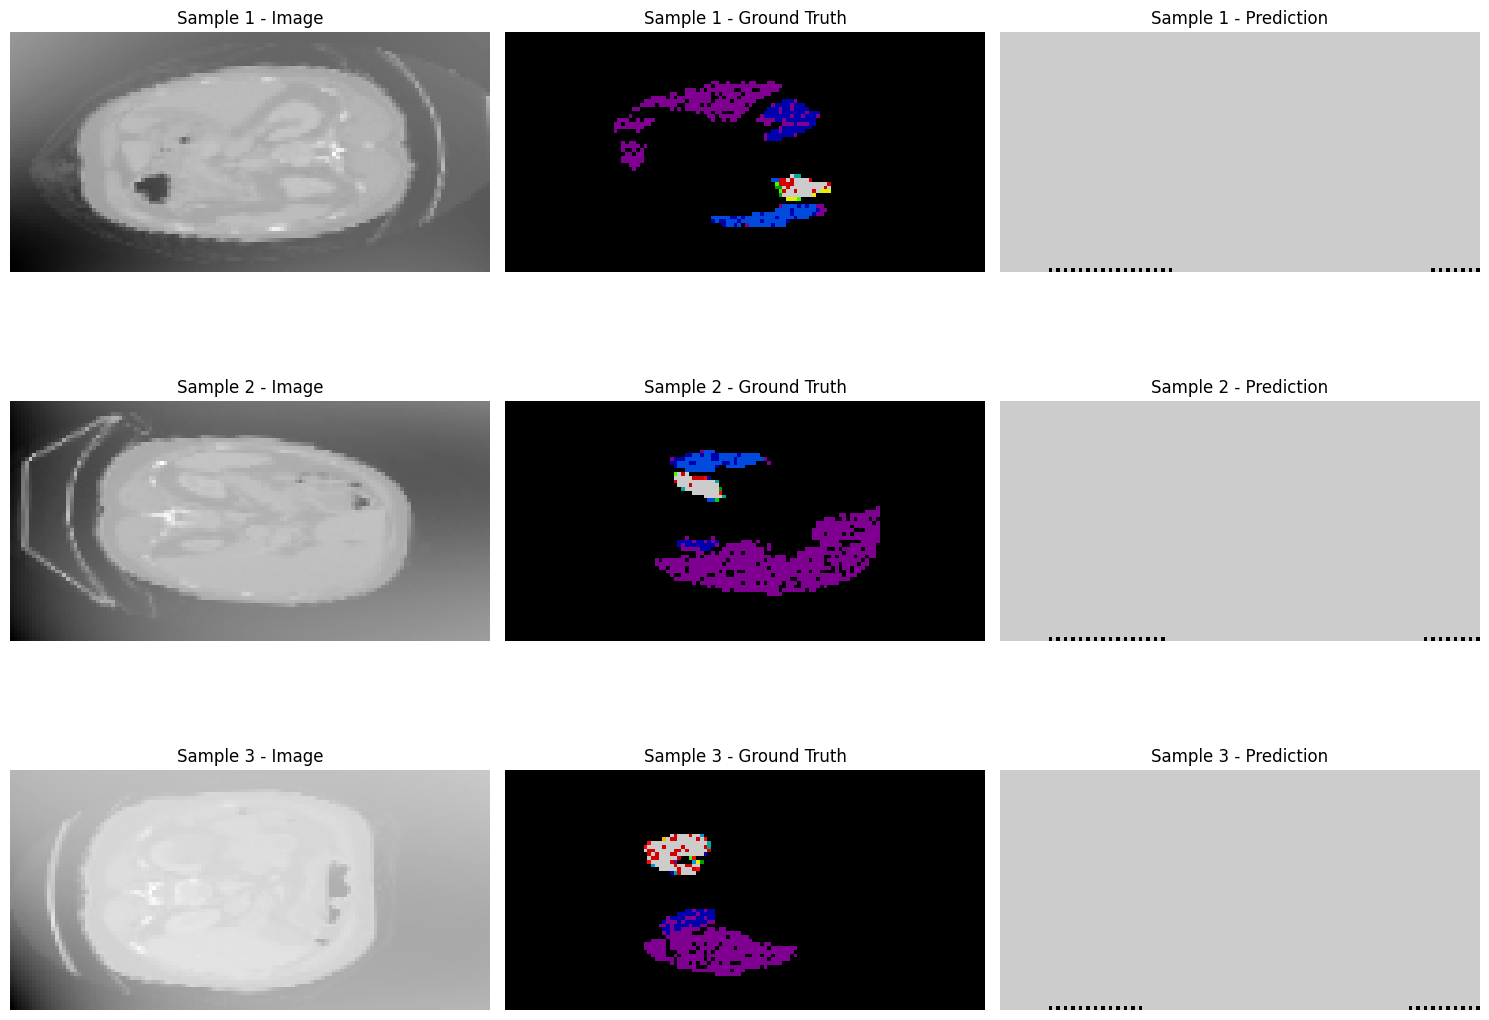

In [71]:
def visualize_predictions(val_loader, model, num_samples=5):
    model.eval()  # Set the model to evaluation mode
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 4 * num_samples))

    with torch.no_grad():  # Disable gradient calculations
        for i, (images, labels) in enumerate(val_loader):
            if i >= num_samples:
                break

            images, labels = images.to(device), labels.to(device)

            # Run the model to get predictions
            outputs = model(images)

            # Convert logits to predicted class (apply argmax along the class dimension)
            predictions = torch.argmax(outputs, dim=1, keepdim=True)  # Now shape is [2, 1, 64, 128, 128]

            # Select the first sample in the batch
            image = images[0].squeeze(0).cpu().numpy()
            label = labels[0].squeeze(0).cpu().numpy()
            prediction = predictions[0].squeeze(0).cpu().numpy()

            print(images.shape)
            print(labels.shape)

            print(outputs.shape)
            print(predictions.shape)

            # Get the middle slice along the z-axis (depth)
            mid_slice = image.shape[2] // 2

            # Plot image
            axes[i, 0].imshow(image[:, :, mid_slice], cmap='gray')
            axes[i, 0].set_title(f'Sample {i+1} - Image')
            axes[i, 0].axis('off')

            # Plot ground truth label
            axes[i, 1].imshow(label[:, :, mid_slice], cmap='nipy_spectral')
            axes[i, 1].set_title(f'Sample {i+1} - Ground Truth')
            axes[i, 1].axis('off')

            # Plot model prediction
            axes[i, 2].imshow(prediction[:, :, mid_slice], cmap='nipy_spectral')
            axes[i, 2].set_title(f'Sample {i+1} - Prediction')
            axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Usage:
visualize_predictions(val_loader, model, num_samples=3)

## 9. Video Generation

In [74]:
import matplotlib.pyplot as plt
import torch
import os

def visualize_3d_predictions_and_save(model, dataset, sample_idx, device='cuda', save_dir='3d_predictions'):
    """
    Visualizes each slice of the original image and model prediction for a specific sample from the dataset,
    and saves the images for video creation.

    Args:
    - model: Trained segmentation model.
    - dataset: Dataset object containing images and labels.
    - sample_idx: Index of the sample to visualize.
    - device: Device on which the model is run ('cuda' or 'cpu').
    - save_dir: Directory where the images will be saved.
    """
    # Set the model to evaluation mode
    model.eval()

    # Create directory if it does not exist
    os.makedirs(save_dir, exist_ok=True)

    # Get the specific sample from the dataset
    image, label = dataset[sample_idx]

    # Move image to the device
    image = image.unsqueeze(0).to(device)  # Add batch dimension and send to device

    # Forward pass to get the prediction
    with torch.no_grad():
        output = model(image)
        prediction = torch.sigmoid(output).squeeze(0).cpu()  # Apply sigmoid to get probabilities, remove batch dimension, and move to CPU

    # Move image and label back to CPU for visualization
    image = image.squeeze(0).cpu()  # Remove batch dimension
    label = label.cpu()

    # Loop over all slices in the z-axis (depth)
    for z in range(image.shape[2]):
        # Plot original image and prediction side by side
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        axes[0].imshow(image[0, :, :, z], cmap='gray')
        axes[0].set_title(f'Sample {sample_idx+1} - Slice {z+1} - Image')
        axes[0].axis('off')

        axes[1].imshow(prediction[0, :, :, z], cmap='nipy_spectral')
        axes[1].set_title(f'Sample {sample_idx+1} - Slice {z+1} - Prediction')
        axes[1].axis('off')

        # Save figure
        fig.savefig(os.path.join(save_dir, f'sample_{sample_idx+1}_slice_{z+1}.png'))
        plt.close(fig)

    print(f"3D images for sample {sample_idx+1} saved to {save_dir}.")

In [75]:
import cv2
import os

def create_3d_video_from_images(image_dir, output_path, fps=5):
    """
    Creates a video from 3D images (slices) stored in a directory.

    Args:
    - image_dir: Directory containing the images.
    - output_path: Path to save the output video.
    - fps: Frames per second for the output video.
    """
    images = sorted([img for img in os.listdir(image_dir) if img.endswith(".png")])
    frame = cv2.imread(os.path.join(image_dir, images[0]))

    # Get the dimensions of the images
    height, width, layers = frame.shape

    # Define the codec and create VideoWriter object
    video = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_dir, image)))

    # Release everything if job is finished
    video.release()
    cv2.destroyAllWindows()

    print(f"3D video saved to {output_path}.")

In [76]:
visualize_3d_predictions_and_save(model, val_dataset, sample_idx=0, device='cuda', save_dir='/content/3d_predictions_1')

3D images for sample 1 saved to /content/3d_predictions_1.


In [77]:
# Example usage:
create_3d_video_from_images(image_dir='/content/3d_predictions_1', output_path='/content/3d_segmentation_predictions_1.mp4', fps=5)


3D video saved to /content/3d_segmentation_predictions_1.mp4.


## 10. Future Improvements

### Model
> Here I used a VNet as suggested in the challenge paper
>
> Other altervatives I would have tried would be the nnUnet, or fine-tuning a SOTA pre-trained model like SAM or detectron2.
>
> Using the open-source monai library was also an option.

### Performance
> I think I was able to obtain a decent dice score, however the predictions seem to be quite off the mark.
> I believe this may be either because of me unable to slice the image correctly for visualizing, or just an issue with the model.

### Improvements
> Possible use of focal loss for criterion and dice loss for metrics
>
> Training for much higher number of epochs
> better augmentation techniques